In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import Adam
from sklearn.metrics import precision_recall_fscore_support

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
x_train = np.load('./datos/x_train.npy')
x_test = np.load('./datos/x_test.npy')
y_train = np.load('./datos/y_train.npy')
y_c1_train = np.load('./datos/y_c1_train.npy')
y_c2_train = np.load('./datos/y_c2_train.npy')

In [4]:
def count_classes(y):
    return np.sum(y, axis=0)

class_counts_y_train = count_classes(y_train)
class_counts_y_c1_train = count_classes(y_c1_train)
class_counts_y_c2_train = count_classes(y_c2_train)

print("Cantidad de imágenes por clase en y_train:", class_counts_y_train)
print("Cantidad de imágenes por clase en y_c1_train:", class_counts_y_c1_train)
print("Cantidad de imágenes por clase en y_c2_train:", class_counts_y_c2_train)

Cantidad de imágenes por clase en y_train: [500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500.]
Cantidad de imágenes por clase en y_c1_train: [ 5000.  7500.  7500.  5000. 12500.  5000.  2500.  5000.]
Cantidad de imágenes por clase en y_c2_train: [2500. 2500. 2500. 2500. 2500. 2500. 2500. 2500. 2500. 2500. 2500. 2500.
 2500. 2500. 2500. 2500. 2500. 2500. 2500. 2500.]


In [5]:
total_count_c1 = sum(class_counts_y_c1_train)
class_weights_c1 = [total_count_c1 / (len(class_counts_y_c1_train) * count) for count in class_counts_y_c1_train]
class_weights_tensor_c1 = torch.FloatTensor(class_weights_c1).to(device)

In [6]:
X_train, X_val, y_train, y_val, y_c1_train, y_c1_val, y_c2_train, y_c2_val = train_test_split(
    x_train, y_train, y_c1_train, y_c2_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [7]:
class HierarchicalDataset(Dataset):
    def __init__(self, x_data, y_data, y_c1_data, y_c2_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32).permute(0, 3, 1, 2) # Permutamos para el formato [batch, channels, height, width] que es el que ocupan las capas Conv2D
        self.y_data = torch.tensor(y_data, dtype=torch.float32)
        self.y_c1_data = torch.tensor(y_c1_data, dtype=torch.float32)
        self.y_c2_data = torch.tensor(y_c2_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Devuelve una muestra junto con sus tres etiquetas
        return self.x_data[idx], self.y_data[idx], self.y_c1_data[idx], self.y_c2_data[idx]

    def shape(self):
        print('x_data shape:', self.x_data.shape, 'tipo dato:', self.x_data.dtype)
        print('y_data shape:', self.y_data.shape, 'tipo dato:', self.y_data.dtype)
        print('y_c1_data shape:', self.y_c1_data.shape, 'tipo dato:', self.y_c1_data.dtype)
        print('y_c2_data shape:', self.y_c2_data.shape, 'tipo dato:', self.y_c2_data.dtype)

train_dataset = HierarchicalDataset(X_train, y_train, y_c1_train, y_c2_train)
val_dataset = HierarchicalDataset(X_val, y_val, y_c1_val, y_c2_val)

In [8]:
def freeze_model(base_model):
  for param in base_model.parameters():
    param.requires_grad = False
  return base_model

In [9]:
efficientnet_b1 = models.efficientnet_b1(weights='EfficientNet_B1_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to C:\Users\joann/.cache\torch\hub\checkpoints\efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 72.6MB/s]


In [ ]:
efficientnet_b1.classifier

In [11]:
class HierarchicalEfficientNet2(nn.Module):
    def __init__(self, base_model, dropout):
        super(HierarchicalEfficientNet2, self).__init__()
        
        # Extraer solo las capas convolucionales de EfficientNetB1
        self.base = base_model.features  # Toma solo las capas convolucionales
        
        # Congelar las capas convolucionales
        for param in self.base.parameters():
            param.requires_grad = False
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Crear las capas fully connected
        self.fc_y1 = nn.Linear(1280, 600)
        self.fc_y2 = nn.Linear(600, 100)  # Para y_train (100 clases)
        self.fc_yc1_1 = nn.Linear(1280, 264)
        self.fc_yc1_2 = nn.Linear(264, 8)  # Para y_c1_train (8 clases)
        self.fc_yc2_1 = nn.Linear(1280, 264)
        self.fc_yc2_2 = nn.Linear(264, 20)  # Para y_c2_train (20 clases)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Extraer características de EfficientNet
        x = self.base(x)
        x = self.global_pool(x) 
        x = torch.flatten(x, 1)

        # Aplicar las capas fully connected para cada etiqueta jerárquica
        y_pred = self.fc_y1(x)
        y_pred = self.relu(y_pred)
        y_pred = self.dropout(y_pred)
        y_pred = self.fc_y2(y_pred)
        
        y_c1_pred = self.fc_yc1_1(x)
        y_c1_pred = self.relu(y_c1_pred)
        y_c1_pred = self.dropout(y_c1_pred)
        y_c1_pred = self.fc_yc1_2(y_c1_pred)

        y_c2_pred = self.fc_yc2_1(x)
        y_c2_pred = self.relu(y_c2_pred)
        y_c2_pred = self.dropout(y_c2_pred)
        y_c2_pred = self.fc_yc2_2(y_c2_pred)

        return y_pred, y_c1_pred, y_c2_pred

In [22]:
def training(model, optimizer, num_epochs, train_loader, val_loader, criterion_y, criterion_y_c1, criterion_y_c2, device):
    # Mover el modelo al dispositivo
    model.to(device)

    # Inicializar listas para almacenar los valores de loss, accuracy, precision, recall y F1
    train_losses, val_losses = [], []
    train_accuracies_y, train_accuracies_y_c1, train_accuracies_y_c2, train_accuracies_total = [], [], [], []
    val_accuracies_y, val_accuracies_y_c1, val_accuracies_y_c2, val_accuracies_total = [], [], [], []
    val_precisions, val_recalls, val_f1_scores = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_y, correct_y_c1, correct_y_c2, correct_total = 0, 0, 0, 0
        total = 0

        for batch in train_loader:
            inputs, labels_y, labels_y_c1, labels_y_c2 = batch  # Desempaquetar el batch

            # Mover los datos al dispositivo
            inputs, labels_y, labels_y_c1, labels_y_c2 = inputs.to(device), labels_y.to(device), labels_y_c1.to(device), labels_y_c2.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes

            # Hacer una pasada hacia adelante
            outputs = model(inputs)

            # Calcular las pérdidas
            loss_y = criterion_y(outputs[0], labels_y)
            loss_y_c1 = criterion_y_c1(outputs[1], labels_y_c1)
            loss_y_c2 = criterion_y_c2(outputs[2], labels_y_c2)
            loss = loss_y + loss_y_c1 + loss_y_c2
            loss.backward()  # Retropropagación
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()

            # Obtener las predicciones
            _, predicted_y = torch.max(outputs[0].data, 1)
            _, predicted_y_c1 = torch.max(outputs[1].data, 1)
            _, predicted_y_c2 = torch.max(outputs[2].data, 1)

            # Convertir labels a índices de clases
            labels_y = torch.argmax(labels_y, dim=1).to(device)
            labels_y_c1 = torch.argmax(labels_y_c1, dim=1).to(device)
            labels_y_c2 = torch.argmax(labels_y_c2, dim=1).to(device)

            total += labels_y.size(0)
            correct_y += (predicted_y == labels_y).sum().item()
            correct_y_c1 += (predicted_y_c1 == labels_y_c1).sum().item()
            correct_y_c2 += (predicted_y_c2 == labels_y_c2).sum().item()
            if (predicted_y == labels_y).all() and (predicted_y_c1 == labels_y_c1).all() and (predicted_y_c2 == labels_y_c2).all():
                correct_total += 1


        # Calcular y almacenar el loss y accuracy promedio para el entrenamiento
        avg_train_loss = running_loss / len(train_loader)
        avg_train_accuracy_y = 100 * correct_y / total
        avg_train_accuracy_y_c1 = 100 * correct_y_c1 / total
        avg_train_accuracy_y_c2 = 100 * correct_y_c2 / total
        avg_train_accuracy_total = 100 * correct_total / total
        train_losses.append(avg_train_loss)
        train_accuracies_y.append(avg_train_accuracy_y)
        train_accuracies_y_c1.append(avg_train_accuracy_y_c1)
        train_accuracies_y_c2.append(avg_train_accuracy_y_c2)
        train_accuracies_total.append(avg_train_accuracy_total)

        # Evaluar el modelo en el conjunto de validación
        model.eval()
        val_running_loss = 0.0
        val_correct_y, val_correct_y_c1, val_correct_y_c2, val_correct_total = 0, 0, 0, 0
        val_total = 0
        val_all_preds_y, val_all_labels_y = [], []
        val_all_preds_y_c1, val_all_labels_y_c1 = [], []
        val_all_preds_y_c2, val_all_labels_y_c2 = [], []

        with torch.no_grad():
            for val_batch in val_loader:
                val_inputs, val_labels_y, val_labels_y_c1, val_labels_y_c2 = val_batch

                # Mover los datos de validación al dispositivo
                val_inputs, val_labels_y, val_labels_y_c1, val_labels_y_c2 = val_inputs.to(device), val_labels_y.to(device), val_labels_y_c1.to(device), val_labels_y_c2.to(device)

                val_outputs = model(val_inputs)

                # Calcular las pérdidas
                val_loss_y = criterion_y(val_outputs[0], val_labels_y)
                val_loss_y_c1 = criterion_y_c1(val_outputs[1], val_labels_y_c1)
                val_loss_y_c2 = criterion_y_c2(val_outputs[2], val_labels_y_c2)
                val_loss = val_loss_y + val_loss_y_c1 + val_loss_y_c2
                val_running_loss += val_loss.item()

                # Obtener las predicciones de validación
                _, val_predicted_y = torch.max(val_outputs[0].data, 1)
                _, val_predicted_y_c1 = torch.max(val_outputs[1].data, 1)
                _, val_predicted_y_c2 = torch.max(val_outputs[2].data, 1)

                # Convertir labels a índices de clases
                val_labels_y = torch.argmax(val_labels_y, dim=1).to(device)
                val_labels_y_c1 = torch.argmax(val_labels_y_c1, dim=1).to(device)
                val_labels_y_c2 = torch.argmax(val_labels_y_c2, dim=1).to(device)

                val_total += val_labels_y.size(0)
                val_correct_y += (val_predicted_y == val_labels_y).sum().item()
                val_correct_y_c1 += (val_predicted_y_c1 == val_labels_y_c1).sum().item()
                val_correct_y_c2 += (val_predicted_y_c2 == val_labels_y_c2).sum().item()
                if (val_predicted_y == val_labels_y).all() and (val_predicted_y_c1 == val_labels_y_c1).all() and (val_predicted_y_c2 == val_labels_y_c2).all():
                    val_correct_total += 1

                # Almacenar todas las predicciones y etiquetas de validación
                val_all_preds_y.extend(val_predicted_y.cpu().numpy())
                val_all_labels_y.extend(val_labels_y.cpu().numpy())
                val_all_preds_y_c1.extend(val_predicted_y_c1.cpu().numpy())
                val_all_labels_y_c1.extend(val_labels_y_c1.cpu().numpy())
                val_all_preds_y_c2.extend(val_predicted_y_c2.cpu().numpy())
                val_all_labels_y_c2.extend(val_labels_y_c2.cpu().numpy())

        # Calcular y almacenar el loss y accuracy promedio para la validación
        avg_val_loss = val_running_loss / len(val_loader)
        avg_val_accuracy_y = 100 * val_correct_y / val_total
        avg_val_accuracy_y_c1 = 100 * val_correct_y_c1 / val_total
        avg_val_accuracy_y_c2 = 100 * val_correct_y_c2 / val_total
        avg_val_accuracy_total = 100 * val_correct_total / val_total
        val_losses.append(avg_val_loss)
        val_accuracies_y.append(avg_val_accuracy_y)
        val_accuracies_y_c1.append(avg_val_accuracy_y_c1)
        val_accuracies_y_c2.append(avg_val_accuracy_y_c2)
        val_accuracies_total.append(avg_val_accuracy_total)

        # Calcular precisión, recall, F1 y soporte para cada nivel
        precision_y, recall_y, f1_y, _ = precision_recall_fscore_support(val_all_labels_y, val_all_preds_y, average='weighted')
        precision_y_c1, recall_y_c1, f1_y_c1, _ = precision_recall_fscore_support(val_all_labels_y_c1, val_all_preds_y_c1, average='weighted')
        precision_y_c2, recall_y_c2, f1_y_c2, _ = precision_recall_fscore_support(val_all_labels_y_c2, val_all_preds_y_c2, average='weighted')
        val_precisions.append((precision_y, precision_y_c1, precision_y_c2))
        val_recalls.append((recall_y, recall_y_c1, recall_y_c2))
        val_f1_scores.append((f1_y, f1_y_c1, f1_y_c2))

        # Imprimir resultados finales de la época
        print(f'\nEpoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}, Accuracies Y/C1/C2: {avg_train_accuracy_y:.2f}%, {avg_train_accuracy_y_c1:.2f}%, {avg_train_accuracy_y_c2:.2f}%, Total Accuracy: {avg_train_accuracy_total:.2f}'
              f' | Validation Loss: {avg_val_loss:.4f}, Accuracies Y/C1/C2: {avg_val_accuracy_y:.2f}%, {avg_val_accuracy_y_c1:.2f}%, {avg_val_accuracy_y_c2:.2f}%, Total Accuracy: {avg_val_accuracy_total}\n')

    # Graficar los resultados
    plt.figure(figsize=(12, 5))

    # Gráfico de pérdidas
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de accuracies de cada nivel
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies_y, label='Training Accuracy Y')
    plt.plot(train_accuracies_y_c1, label='Training Accuracy Y_c1')
    plt.plot(train_accuracies_y_c2, label='Training Accuracy Y_c2')
    plt.plot(train_accuracies_total, label='Training Accuracy Total')
    plt.plot(val_accuracies_y, label='Validation Accuracy Y')
    plt.plot(val_accuracies_y_c1, label='Validation Accuracy Y_c1')
    plt.plot(val_accuracies_y_c2, label='Validation Accuracy Y_c2')
    plt.plot(val_accuracies_total, label='Validation Accuracy Total')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return train_losses, val_losses, train_accuracies_total, train_accuracies_y, train_accuracies_y_c1, train_accuracies_y_c2, val_accuracies_total, val_accuracies_y, val_accuracies_y_c1, val_accuracies_y_c2, val_precisions, val_recalls, val_f1_scores



In [23]:
dropout = 0.2
model = HierarchicalEfficientNet2(efficientnet_b1, dropout=0.5).to(device)

In [24]:
learning_rate = 0.001
num_epochs = 5
batch_size = 164
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion_y = nn.CrossEntropyLoss()
criterion_y_c1 = nn.CrossEntropyLoss(weight=class_weights_tensor_c1)
criterion_y_c2 = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

C:\Users\joann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch [1/5] Training Loss: 8.0258, Accuracies Y/C1/C2: 12.76%, 39.70%, 25.70%, Total Accuracy: 0.00 | Validation Loss: 6.7468, Accuracies Y/C1/C2: 22.72%, 48.13%, 36.00%, Total Accuracy: 0.0


Epoch [2/5] Training Loss: 7.1995, Accuracies Y/C1/C2: 19.64%, 44.13%, 31.07%, Total Accuracy: 0.00 | Validation Loss: 6.5900, Accuracies Y/C1/C2: 24.49%, 49.63%, 36.87%, Total Accuracy: 0.0


Epoch [3/5] Training Loss: 7.0554, Accuracies Y/C1/C2: 21.43%, 44.71%, 32.48%, Total Accuracy: 0.00 | Validation Loss: 6.5149, Accuracies Y/C1/C2: 25.43%, 48.63%, 37.48%, Total Accuracy: 0.0


Epoch [4/5] Training Loss: 6.9797, Accuracies Y/C1/C2: 21.92%, 45.35%, 32.95%, Total Accuracy: 0.00 | Validation Loss: 6.4281, Accuracies Y/C1/C2: 26.25%, 49.29%, 37.82%, Total Accuracy: 0.0


Epoch [5/5] Training Loss: 6.9057, Accuracies Y/C1/C2: 22.50%, 45.58%, 33.26%, Total Accuracy: 0.00 | Validation Loss: 6.4475, Accuracies Y/C1/C2: 25.76%, 50.59%, 37.72%, Total Accuracy: 0.0



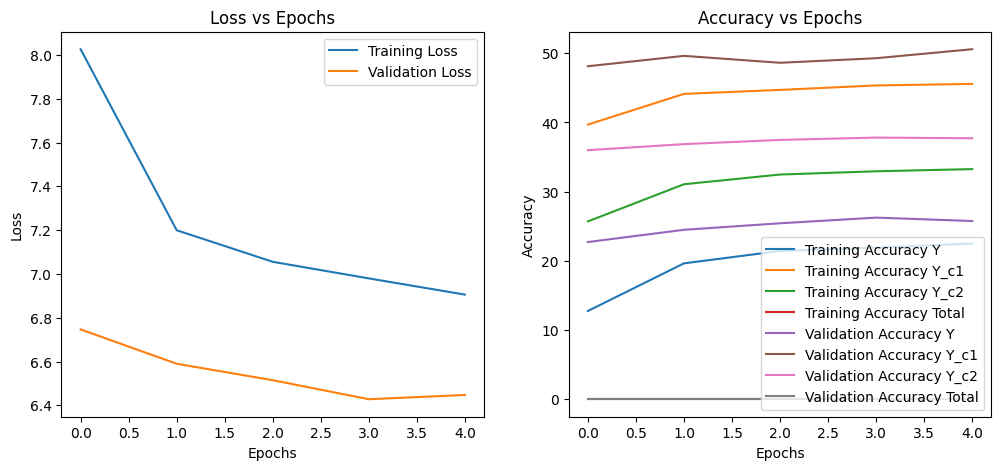

In [25]:
train_losses, val_losses, train_accuracies_total, train_accuracies_y, train_accuracies_y_c1, train_accuracies_y_c2, val_accuracies_total, val_accuracies_y, val_accuracies_y_c1, val_accuracies_y_c2, val_precisions, val_recalls, val_f1_scores = training(model, optimizer, num_epochs, train_loader, val_loader, criterion_y, criterion_y_c1, criterion_y_c2, device)

In [68]:
class HierarchicalDatasetPredict(Dataset):
    def __init__(self, x_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        return self.x_data[idx]

ids = list(range(len(x_test)))

x_test_dataset = HierarchicalDatasetPredict(x_test)

# Create a DataLoader for your dataset
batch_size = 32  # Adjust batch size as needed
test_loader = DataLoader(x_test_dataset, batch_size=batch_size, shuffle=False)

# Switch the model to evaluation mode
model_1.eval()

submit_data = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        outputs = model_1(data)  # Ensure 'data' is a tensor

        y_pred = outputs[0]
        y_c1_pred = outputs[1]
        y_c2_pred = outputs[2]

        y_pred = y_pred.cpu()
        y_c1_pred = y_c1_pred.cpu()
        y_c2_pred = y_c2_pred.cpu()

        y_pred_class = y_pred.argmax(dim=1).numpy()
        y_c1_pred_class = y_c1_pred.argmax(dim=1).numpy()
        y_c2_pred_class = y_c2_pred.argmax(dim=1).numpy()

        # Collect predictions for each batch
        for j in range(len(y_pred_class)):
            submit_data.append(f"{i*batch_size + j}, {y_c1_pred_class[j]} {y_c2_pred_class[j]} {y_pred_class[j]}")

# Write the results to 'submit.csv'
with open('submit.csv', 'w') as file:
    file.write("ID,Prediction\n")
    for line in submit_data:
        file.write(line + "\n")